In [1]:
!nvidia-smi

Thu Sep  9 09:13:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install required libs  
# NOTE: Run this one code, then restart this runtime and run again for next all... (PENTING!!!) 

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

In [3]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1

In [4]:
!pip install h5py==2.10.0

In [5]:
## Imports libs
## sebelum jalanin code ini restart runtime dulu, karena berpengaruh pada code line awal
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
drive_link = '/content/drive/My Drive/'
my_link = drive_link+'SKRIPSI/'

In [8]:
DATA_DIR = my_link+'dataset/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
  print('Dataset not exist...')
else:
  print('Dataset Exist...')

Dataset Exist...


### Data Generator
###### ``Data Generator adalah kelas generator dataset yang dibungkus per batch sesuai dengan ukuran batch, ``
###### ``misal (batch_size, pixel_width, pixel_height, channel_size) = (8,128,128,3)``
###### ``penambahan dropout pada model``

In [9]:

class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=256, augmentation=None, preprocessing=None): 
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __load__(self,id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, "masks", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path, 0)
        image = cv2.resize(image, (self.image_size, self.image_size))
        #image = np.expand_dims(image, axis=-1)
        
        
        ## Reading Masks
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        ## Jumlah Batch Terakhir Disesuaikan Sisa Data Yang Ada
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        ## Load Data Dengan Fungsi __load__
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)  
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        image = np.repeat(image[..., np.newaxis], 3, -1)

        return image, mask
        
    def augmentation(self):
        sample = self.ids (image=image, mask=mask)
        image, mask = sample ['image'], sample['mask']
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

## Augmentasi

In [10]:
import albumentations as A

In [11]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():

    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [12]:
# Data jantung generate ids

train_path = DATA_DIR
jantung_path = '/content/drive/My Drive/SKRIPSI/dataset/jantung_idx.txt' # daftar nama data jantung ada disini
load_jt_ids = []

# Load idx dataset jantung
with open(jantung_path, 'rb') as handle: 
    load_jt_ids = [str(line.rstrip())[2:-1] for line in handle]

# Membagi dataset menjadi train, valid, test = 64%, 16%, 20% 
train_jt_ids = load_jt_ids[:int(5011*0.64)+1]
valid_jt_ids = load_jt_ids[int(5011*0.64)+1:-int(5011*0.20)]
test_jt_ids = load_jt_ids[-int(5011*0.20):]

print('Jumlah data jantung (train, valid, test) = (',len(train_jt_ids), ',', len(valid_jt_ids), ',', len(test_jt_ids),').')
print('Total dataset: ',len(train_jt_ids)+len(valid_jt_ids)+len(test_jt_ids))
print('Contoh data:',load_jt_ids[-1])
        

Jumlah data jantung (train, valid, test) = ( 3208 , 801 , 1002 ).
Total dataset:  5011
Contoh data: sol_033_z_pos_010_t_pos_020


### Hyperparameters

In [13]:
############____________________________________________________________############

# Definisikan model dan parameter yang diinginkan... 
# Definisi parameter ini akan digenerate otomatis oleh fungsi-fungsi dibawahnya

model_path = 'unet_mobilenet_jt_0.0001_50_256_yes'

############____________________________________________________________############

Definisikan model_path: ``{decoder}_{encoder}_jt_{learning_rate}_{epochs}_{image_size}_{pretrained_imagenet?}``

**Berikut definisi encoder di sm-model:**
##### ``VGG``	: 'vgg16', 'vgg19'
##### ``ResNet``	: 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
##### ``SENet154``	: 	'senet154'
##### ``DenseNet``	: 	'densenet121', 'densenet169', 'densenet201'
##### ``Inception``	: 	'inceptionv3', 'inceptionresnetv2'
##### ``MobileNet``	: 	'mobilenet', 'mobilenetv2'
##### ``EfficientNet``	: 	'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5' efficientnetb6', efficientnetb7'

**Berikut definisi decoder di sm-model:**
- unet
- linknet
- pspnet
- fpn

#### Fungsi dan Tools

In [14]:
# Posisi direktori model
save_dir =  [
              '/content/drive/My Drive/SKRIPSI/moled/',
            ]

In [15]:
# Fungsi untuk mengolah history
import json, codecs, pickle

def saveHist(path, history):
    with open(path, 'wb') as handle: # saving the history of the model
        pickle.dump(history, handle)

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with open(path, 'rb') as handle: # loading old history 
            n = pickle.load(handle)
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [16]:
import segmentation_models as sm


# Mengambil Model Yang Sudah Ada
def take_model(model_path):
    print('Melanjutkan: ',model_path)
    md_ = model_path.split('_')
    lr = float(md_[3])
    epochs = int(md_[4])
    image_size = int(md_[5])
    pretrained = md_[6]
    batch_size = 8
    print('lr:',lr,', epochs:',epochs,', im_size:',image_size,', prt: '+pretrained)
    # optim, loss, metric harus sesuai dengan model yang ditraining sebelumnya
    optim = keras.optimizers.Adam(lr)
    total_loss = sm.losses.JaccardLoss()
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5),'accuracy']

    model = keras.models.load_model(save_dir[0]+model_path+'/'+model_path+'.h5', custom_objects={'jaccard_loss': total_loss, 'iou_score':metrics[0], 'f1-score':metrics[1], 'precision_score':metrics[2], 'recall_score':metrics[3]})

    return model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim

# Mengatur Dataset
def set_data(train_ids,test_ids,valid_ids):
    train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size, augmentation=get_training_augmentation())
    test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=batch_size, augmentation=get_training_augmentation())
    valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size, augmentation=get_training_augmentation())

    train_steps = len(train_ids)//batch_size
    test_steps = len(test_ids)//batch_size
    valid_steps = len(valid_ids)//batch_size

    return train_gen,test_gen,valid_gen,train_steps,test_steps,valid_steps

# Melanjutkan Training
def cont_training(model):
    print('Lanjutkan Training... '+model.name)   
    path = save_dir[0]+model.name+'/'+model.name
    old_hist = loadHist(path+'_history.bin')
    initial_epoch = len(old_hist['loss'])
    print('Dari epochs',initial_epoch)
    if initial_epoch>=500 or initial_epoch==50 or initial_epoch==250:
        print("Batal Training, Model Sudah Memenuhi Epochs "+str(initial_epoch))
    else:
        # define callbacks for learning rate scheduling and best checkpoints saving
        callbacks = [
            keras.callbacks.ModelCheckpoint(path+'_best_weights.h5', monitor='val_iou_score', save_weights_only=True, save_best_only=True, mode='max'),
        ]
        saveHist(path+'_history_temp_'+str(initial_epoch)+'.bin', old_hist)
        model.save(path+'_temp_'+str(initial_epoch)+'.h5')
        model.fit_generator(train_gen, 
                            validation_data=valid_gen, 
                            steps_per_epoch=train_steps, 
                            validation_steps=valid_steps, 
                            epochs=initial_epoch+epochs,
                            initial_epoch=initial_epoch,
                            augmentation=augmentation,
                            callbacks=callbacks)
        print('Menyimpan Model...')    
        model.save(path+'.h5')
        history = model.history
        model.history.history = appendHist(old_hist, history.history)
        saveHist(path+'_history.bin', model.history.history)
        if initial_epoch>=400:
            train_vis(model.history.history, path, doing="save")
        print('Berhasil Menyimpan Model')


Segmentation Models: using `keras` framework.


In [17]:

# Membuat Model SM Baru
def take_sm(model_path):
    print('Memulai SM-Model: ',model_path)
    try:
        # apakah model sudah pernah dibuat?
        os.mkdir(save_dir[0]+model_path)
    except:
        print('Overwrite '+model_path)
    md_ = model_path.split('_')
    lr = float(md_[3])
    epochs = int(md_[4])
    image_size = int(md_[5])
    pretrained = md_[6]
    batch_size = 8
    print('lr:',lr,', epochs:',epochs,', im_size:',image_size,', prt: '+pretrained)
    # optimizer manual setting 
    optim = keras.optimizers.Adam(lr)
    # loss function manual setting
    total_loss = sm.losses.JaccardLoss()
    # metric evaluation manual setting
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5),'accuracy']
    if pretrained=='yes': encoder_weights = 'imagenet'
    else: encoder_weights = None
    if md_[0] is 'unet':
        model = sm.Unet(md_[1],classes=1, activation='sigmoid', input_shape=(image_size,image_size,3), encoder_weights=encoder_weights) 
    elif md_[0] is 'linknet':
        model = sm.Linknet(md_[1], classes=1, activation='sigmoid', input_shape=(image_size,image_size,3), encoder_weights=encoder_weights) 
    elif md_[0] is 'pspnet':
        model = sm.PSPNet(md_[1], classes=1, activation='sigmoid', input_shape=(image_size,image_size,3), encoder_weights=encoder_weights) 
    elif md_[0] is 'fpn':
        model = sm.FPN(md_[1], classes=1, activation='sigmoid', input_shape=(image_size,image_size,3), encoder_weights=encoder_weights) 
    else: 
        model = sm.Unet(md_[1], classes=1, activation='sigmoid', input_shape=(image_size,image_size,3), encoder_weights=encoder_weights) 
    model.compile(optim, total_loss, metrics)
    # auto set model name with model_path
    model._name = model_path
    return model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim

#### Persiapan Model

In [18]:
##########____________________________________________ Pengaturan Model dan Dataset ____________________________________________##########

### Untuk mengambil model sm, menggunakan fungsi take_model() ###
#model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim = take_model(model_path)
#train_gen, test_gen, valid_gen, train_steps, test_steps, valid_steps = set_data(train_jt_ids,test_jt_ids,valid_jt_ids)

#model baru
model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim = take_sm(model_path)
train_gen, test_gen, valid_gen, train_steps, test_steps, valid_steps = set_data(train_jt_ids,test_jt_ids,valid_jt_ids)

Memulai SM-Model:  unet_mobilenet_jt_0.0001_50_256_yes
Overwrite unet_mobilenet_jt_0.0001_50_256_yes
lr: 0.0001 , epochs: 50 , im_size: 256 , prt: yes


/root/.local/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

#### Fungsi Training Testing dan Evaluasi

In [19]:
from matplotlib import pyplot as plt
from keras.utils import plot_model
import json, codecs, pickle
import pandas as pd

# helper function for training visualization
def train_vis(history, model_save_dir, doing="show"):
    # Plot training & validat accuray values
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    if (doing=="save"):
        plt.savefig(model_save_dir+'_plot.png')
        print("Success Saving Plot")
        plt.clf()
    else: 
        plt.show()

# helper function for training 
def train_fit(model_, epochs=epochs, pretrain=False):
    print("Training for "+model_._name)
    callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir[0]+"{}/{}".format(model_._name,model_._name)+'_best_weights.h5', monitor='val_iou_score', save_weights_only=True, save_best_only=True, mode='max'),
    ]
    model_.fit_generator( train_gen, 
                          validation_data=valid_gen, 
                          steps_per_epoch=train_steps, 
                          validation_steps=valid_steps, 
                          epochs=epochs,
                          callbacks=callbacks)
        
    if pretrain:
        return 0
        
    try:
        os.mkdir(save_dir[0]+model_._name)
    except FileExistsError:
        print('Directory not created, '+model_._name+' was exist!')

    model_save_dir = save_dir[0]+model_._name+'/'+model_._name

    plot_model(model_, show_shapes=True, to_file=model_save_dir+'_architecture.png')

    train_vis(model_.history.history, model_save_dir, doing="save")

    with open(model_save_dir+'_history.bin', 'wb') as handle:
        pickle.dump(model_.history.history, handle)
    
    model_.save(model_save_dir+'.h5')
    print("Success Saving Model")

# helper function for testing 
def test_eval(model_):
    i_=0
    list_of_test = []
    print("Testing for "+model_._name)
    scores = model_.evaluate_generator(test_gen)
    list_of_test.append("Loss: {:.5}".format(scores[0]))
    print(list_of_test[i_])
    for metric, value in zip(metrics, scores[1:]):
        i_ += 1
        try:
            list_of_test.append("mean {}: {:.5}".format(metric.__name__, value))
        except: 
            list_of_test.append("mean accuracy : {:.5}".format(value))
        print(list_of_test[i_])

    model_save_dir = save_dir[0]+model_._name+'/'+model_._name
    
    with open(model_save_dir+'_scores.txt', 'w') as f:
        for item in list_of_test:
            f.write("%s\n" % item)

    return scores


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# helper function for test result and visualization
def test_vis(model, test_ids=test_jt_ids, evals=False):
    # new definition test data 
    test_dataset = DataGen(test_ids, train_path, image_size=image_size, batch_size=1)
    
    loss_ = []
    ious_ = []
    f1s_ = []
    recall_ = []
    precision_ = []
    task_ = ''

    if evals:
        jml = len(test_dataset)
        ids = range(0,jml)
        task_ = 'Sukses mengevaluasi model '+model._name+', dengan jumlah data_test: '+str(jml)
    else:
        #n = 5
        #ids = np.random.choice(np.arange(len(test_dataset)), size=n)
        jml = len(test_dataset)
        ids = range(0,jml)

    # visualize
    for i in ids:
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image[0], axis=0)
        pr_mask = model.predict(image).round()
      
        if not evals:
            visualize(
                image=denormalize(image.squeeze()),
                gt_mask=gt_mask[0][..., 0].squeeze(),
                pr_mask=pr_mask[0][..., 0].squeeze(),
            )
        else:
            scores = model.evaluate(image,gt_mask)
            
            if (i+1) % 10 == 0 :
                print('['+str(i+1)+'/'+str(jml)+'] --- dari progres ---')
            
            loss_.append(scores[0])
            ious_.append(scores[1])
            f1s_.append(scores[2])
            recall_.append(scores[3])
            precision_.append(scores[4])

    if evals:
        df = pd.DataFrame({'id': test_ids[:jml], 'loss': loss_, 'iou-score': ious_, 'f1-score': f1s_, 'precision_score': precision_, 'recall_score': recall_})
        df.to_csv(save_dir[0]+model._name+'/'+model._name+'_eval_test.csv',index=False)
    print()
    print(task_)


In [20]:
round(0.1284*100,1)

12.8

In [21]:
# Load weights in the best scores for each overall epoh
# model.load_weights('/content/drive/My Drive/PENELITIAN/models/unet_mobilenet_17a_0.001_100_256_yes/unet_mobilenet_17a_0.001_100_256_yes_best_weights.h5')

#### Train The Models

In [22]:
## Melanjutkan Training
#cont_training(model)

# Training Model Baru
train_fit(model)

Training for unet_mobilenet_jt_0.0001_50_256_yes
Epoch 1/50
401/401 [==============================] - 3051s 8s/step - loss: 0.9117 - iou_score: 0.2688 - f1-score: 0.3962 - precision: 0.2706 - recall: 0.9848 - accuracy: 0.9097 - val_loss: 0.7838 - val_iou_score: 0.4308 - val_f1-score: 0.5914 - val_precision: 0.5106 - val_recall: 0.7368 - val_accuracy: 0.9854
Epoch 2/50
401/401 [==============================] - 174s 435ms/step - loss: 0.4607 - iou_score: 0.6716 - f1-score: 0.7951 - precision: 0.7278 - recall: 0.9122 - accuracy: 0.9950 - val_loss: 0.3150 - val_iou_score: 0.7362 - val_f1-score: 0.8467 - val_precision: 0.8867 - val_recall: 0.8157 - val_accuracy: 0.9954
Epoch 3/50
401/401 [==============================] - 174s 433ms/step - loss: 0.2585 - iou_score: 0.7725 - f1-score: 0.8690 - precision: 0.8426 - recall: 0.9062 - accuracy: 0.9972 - val_loss: 0.2672 - val_iou_score: 0.7553 - val_f1-score: 0.8588 - val_precision: 0.9309 - val_recall: 0.8057 - val_accuracy: 0.9962
Epoch 4/50


<Figure size 2160x360 with 0 Axes>

In [23]:
#model = keras.models.load_model('/content/drive/My Drive/SKRIPSI/models/unet_mobilenet_jt_0.001_15_256_yes/unet_mobilenet_jt_0.001_15_256_yes.h5',custom_objects={'jaccard_loss': total_loss, 'iou_score':metrics[0], 'f1-score':metrics[1]})

In [24]:
#model.load_weights('/content/drive/My Drive/SKRIPSI/models/unet_mobilenet_jt_0.001_15_256_yes/unet_mobilenet_jt_0.001_15_256_yes.h5')

#### Test The Models 
`*(Tidak perlu dijalankan jika masih checkpoint)*`

In [25]:
test_eval(model)

Testing for unet_mobilenet_jt_0.0001_50_256_yes


/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 76 could not be retrieved. It could be because a worker has died.
  UserWarning)


Loss: 0.35567
mean iou_score: 0.7184
mean f1-score: 0.83307
mean precision: 0.89785
mean recall: 0.78452
mean accuracy : 0.99665


[0.3556680679321289,
 0.7183964252471924,
 0.8330709338188171,
 0.8978451490402222,
 0.784518301486969,
 0.9966544508934021]

In [26]:
test_vis(model, test_ids=test_jt_ids, evals=True)


1/1 [==============================] - 0s 25ms/step
[10/1002] --- dari progres ---
1/1 [==============================] - 0s 27ms/step
[20/1002] --- dari progres ---
1/1 [==============================] - 0s 25ms/step
[30/1002] --- dari progres ---
1/1 [==============================] - 0s 25ms/step
[40/1002] --- dari progres ---
1/1 [==============================] - 0s 24ms/step
[50/1002] --- dari progres ---
1/1 [==============================] - 0s 26ms/step
[60/1002] --- dari progres ---
1/1 [==============================] - 0s 28ms/step
[70/1002] --- dari progres ---
1/1 [==============================] - 0s 24ms/step
[80/1002] --- dari progres ---
1/1 [==============================] - 0s 24ms/step
[90/1002] --- dari progres ---
1/1 [==============================] - 0s 25ms/step
[100/1002] --- dari progres ---
1/1 [==============================] - 0s 24ms/step
[110/1002] --- dari progres ---
1/1 [==============================] - 0s 25ms/step
[120/1002] --- dari progres ---
1

#### Evaluasi Gambar
``Print kondisi setiap channel pada setiap layer untuk gambar yang akan didefinisikan``

In [ ]:
load_csvs = save_dir[0]+model._name+"/"+model._name+"_eval_test.csv"

In [ ]:
pd.read_csv(load_csvs)

id      loss  ...  precision_score  recall_score
0     sol_028_z_pos_003_t_pos_009  0.173811  ...         0.903196      0.905749
1     sol_028_z_pos_003_t_pos_010  0.189332  ...         0.845476      0.953069
2     sol_028_z_pos_003_t_pos_011  0.300742  ...         0.747143      0.915937
3     sol_028_z_pos_003_t_pos_012  0.436759  ...         0.581855      0.944629
4     sol_028_z_pos_003_t_pos_013  0.279839  ...         0.766390      0.924276
...                           ...       ...  ...              ...           ...
997   sol_033_z_pos_010_t_pos_016  0.429885  ...         0.673684      0.790123
998   sol_033_z_pos_010_t_pos_017  0.424990  ...         0.668919      0.801619
999   sol_033_z_pos_010_t_pos_018  0.524299  ...         0.547703      0.767327
1000  sol_033_z_pos_010_t_pos_019  0.557680  ...         0.493902      0.835052
1001  sol_033_z_pos_010_t_pos_020  0.637142  ...         0.408602      0.767677

[1002 rows x 6 columns]

In [ ]:
dfcsv = pd.read_csv(load_csvs).sort_values('iou-score')
nilai_iou = []
# dfcsv
for niou in dfcsv['iou-score']:
     nilai_iou.append(int(round(niou*100,0)))
nilai_iou[0] = 1


In [ ]:
index_ = list(pd.DataFrame(nilai_iou)[0].value_counts().index)
values_ = list(pd.DataFrame(nilai_iou)[0].value_counts())

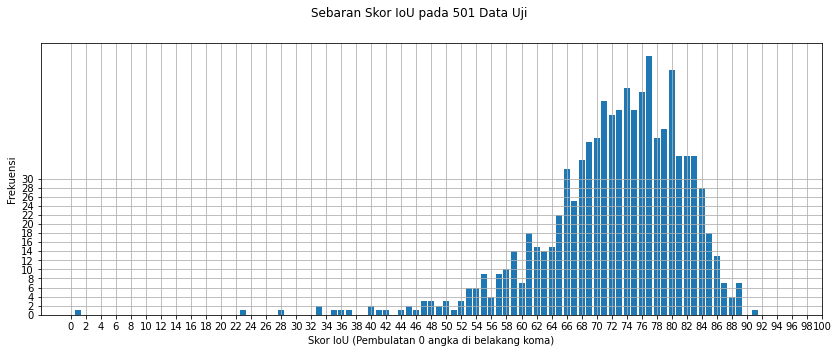

In [ ]:
names = index_
values = values_

plt.figure(figsize=(14, 5))

plt.bar(names, values)
plt.xticks(list(range(0,101,2)))
plt.yticks(list(range(0,31,2)))
plt.xlabel('Skor IoU (Pembulatan 0 angka di belakang koma)')
plt.ylabel('Frekuensi')
plt.grid()
plt.suptitle('Sebaran Skor IoU pada 1002 Data Uji')
plt.show()

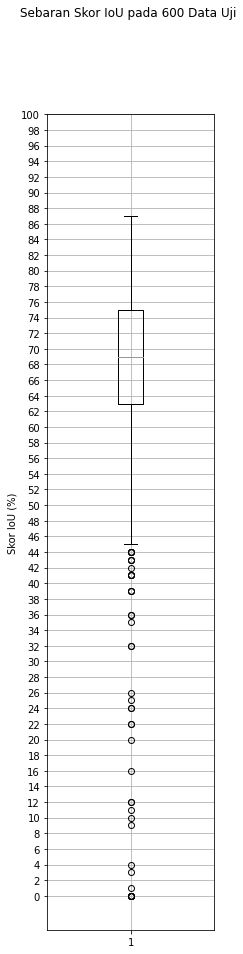

In [ ]:
names = index_
values = values_

plt.figure(figsize=(3, 15))

plt.boxplot(nilai_iou)
plt.ylabel('Skor IoU (%)')
plt.yticks(list(range(0,101,2)))
plt.grid()
plt.suptitle('Sebaran Skor IoU pada 600 Data Uji')
plt.show()

In [ ]:
dfcsv = pd.read_csv(load_csvs).sort_values('iou-score')
print(dfcsv[dfcsv['iou-score']<0.1].count()[0])
print(dfcsv[dfcsv['iou-score']>=0.1][dfcsv['iou-score']<=0.5].count()[0])
print(dfcsv[dfcsv['iou-score']>0.5][dfcsv['iou-score']<=0.85].count()[0])
print(dfcsv[dfcsv['iou-score']>0.85][dfcsv['iou-score']<=0.95].count()[0])
print(dfcsv[dfcsv['iou-score']>0.95].count()[0])

10
46
942
4
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [ ]:
pd.read_csv(load_csvs)['iou-score'].sum()/600

1.1216770702011318

In [ ]:
print('Hasil ini digunakan pada model yang dilatih dengan batch_size 8')
print()
test_dataset = DataGen(test_jt_ids, train_path, image_size=image_size, batch_size=8)
hasils = model.evaluate_generator(test_dataset)
print("Hasil pengujian dengan batch_size = 8 (sesuai ukuran pelatihan)")
print("Loss: ",hasils[0])
print("IoU-Score: ",hasils[1])
print("F1-Score: ",hasils[2])
print("accuracy: ",hasils[3])
print("precision: ",hasils[4])
print("recall: ", hasils[5])
print()

test_dataset = DataGen(test_jt_ids, train_path, image_size=image_size, batch_size=1)
hasils = model.evaluate_generator(test_dataset)
print("Hasil pengujian dengan batch_size = 1 (satu-per-satu gambar)")
print("Loss: ",hasils[0])
print("IoU-Score: ",hasils[1])
print("F1-Score: ",hasils[2])
print("accuracy: ",hasils[3])
print("precision: ",hasils[4])
print("recall: ", hasils[5])

Hasil ini digunakan pada model yang dilatih dengan batch_size 8

Hasil pengujian dengan batch_size = 8 (sesuai ukuran pelatihan)
Loss:  0.31048446893692017
IoU-Score:  0.672604501247406
F1-Score:  0.7978807091712952
accuracy:  0.8454309105873108
precision:  0.7719545364379883
recall:  0.9937623739242554

Hasil pengujian dengan batch_size = 1 (satu-per-satu gambar)
Loss:  0.7636217474937439
IoU-Score:  0.6716629266738892
F1-Score:  0.7954027652740479
accuracy:  0.8462709188461304
precision:  0.7719976305961609
recall:  0.9937611222267151


In [ ]:
dfcsv = pd.read_csv(load_csvs).sort_values('iou-score')
test_id1 = list(dfcsv['id'][dfcsv['iou-score']<0.1])
test_id2 = list(dfcsv['id'][dfcsv['iou-score']>=0.1][dfcsv['iou-score']<=0.5])
test_id3 = list(dfcsv['id'][dfcsv['iou-score']>0.5][dfcsv['iou-score']<=0.85])
test_id4 = list(dfcsv['id'][dfcsv['iou-score']>0.85][dfcsv['iou-score']<=0.95])
test_id5 = list(dfcsv['id'][dfcsv['iou-score']>0.95])

In [ ]:
def fungsi_vis(i,test_id1):
  test_dataset = DataGen(test_id1, train_path, image_size=image_size, batch_size=1)
  plt.figure(figsize=(16, 5))
  image, gt_mask = test_dataset[i]
  image = np.expand_dims(image[0], axis=0)
  pr_mask = model.predict(image).round()
  scores = model.evaluate(image,gt_mask)
  b,g,r = cv2.split(image[0])
  rgb_img = cv2.merge([r,g,b])
  # imagess = np.expand_dims(rgb_img, axis=0)

  contours1, hierarchy1 = cv2.findContours(np.array(gt_mask[0], dtype=np.uint8).squeeze(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  largest_contour1 = []
  largest_area = 0
  for contour in contours1:
      area = cv2.contourArea(contour)
      if area > largest_area:
          largest_area = area
          largest_contour1 = contour
  cv2.drawContours(rgb_img, [largest_contour1], -2, (1, 1, 0), 1)

  contours2, hierarchy2 = cv2.findContours(np.array(pr_mask, dtype=np.uint8).squeeze(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
  largest_contour2 = []
  largest_area = 0
  for contour in contours2:
      area = cv2.contourArea(contour)
      if area > largest_area:
          largest_area = area
          largest_contour2 = contour
  cv2.drawContours(rgb_img, [largest_contour2], -1, (0, 1, 1), 1)
  ious = str(scores[1]*100)[:str(scores[1]*100).find(".")+3] + '%'
  titles = test_id1[i]+" ("+ious+")"
  plt.title(titles)
  plt.imshow(denormalize(rgb_img.squeeze()))

1/1 [==============================] - 0s 9ms/step


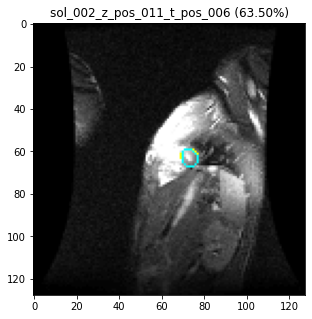

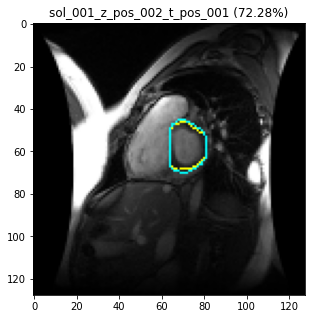

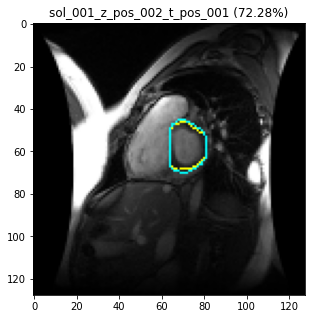

In [ ]:
for i in range(len(['sol_002_z_pos_011_t_pos_006','sol_001_z_pos_002_t_pos_001','sol_001_z_pos_002_t_pos_001'])):
  fungsi_vis(i,['sol_002_z_pos_011_t_pos_006','sol_001_z_pos_002_t_pos_001','sol_001_z_pos_002_t_pos_001'])

1/1 [==============================] - 0s 11ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 0s 12ms/step


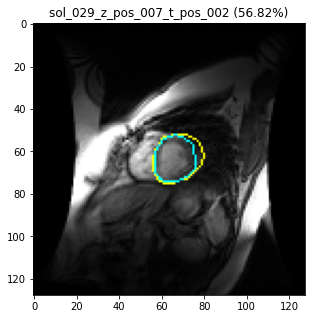

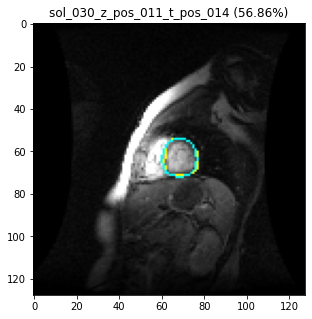

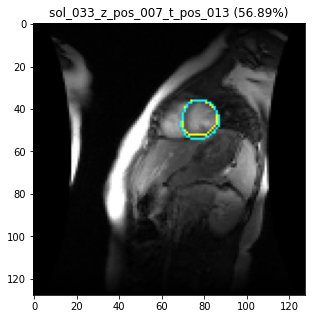

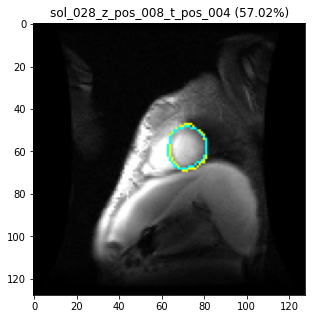

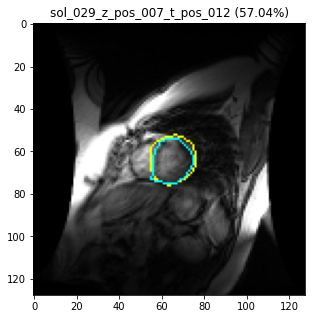

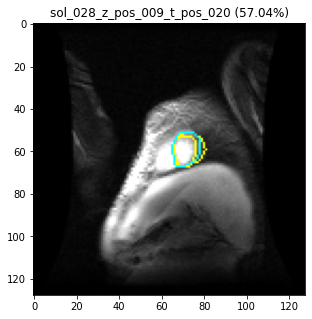

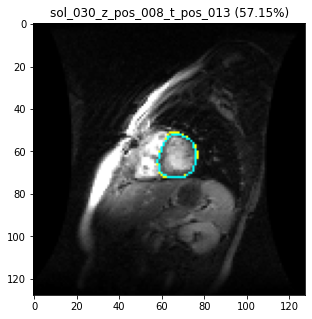

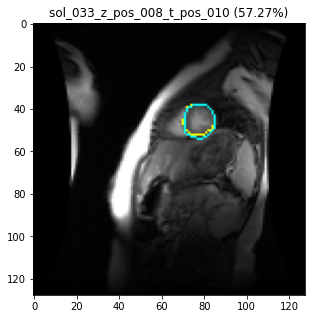

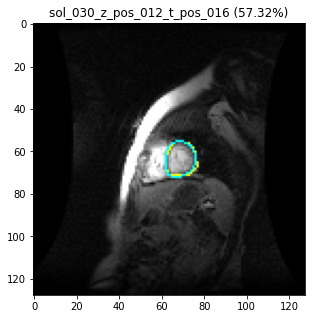

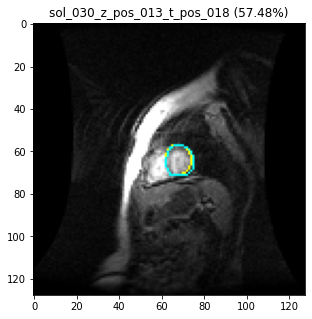

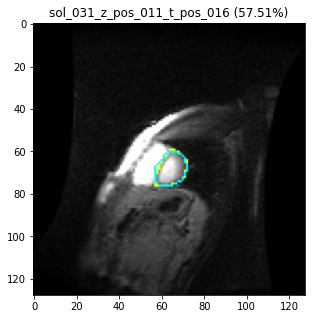

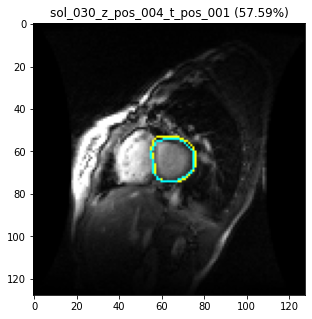

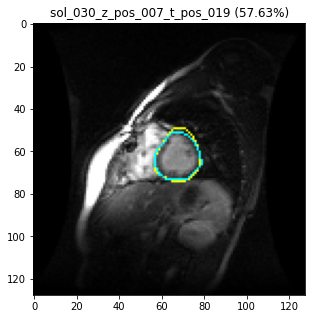

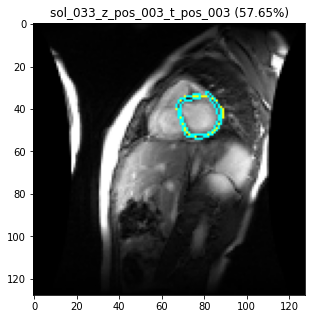

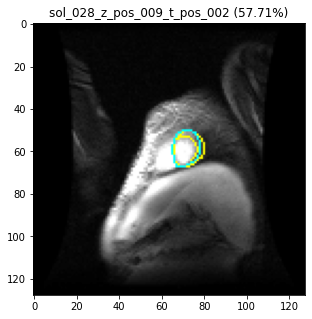

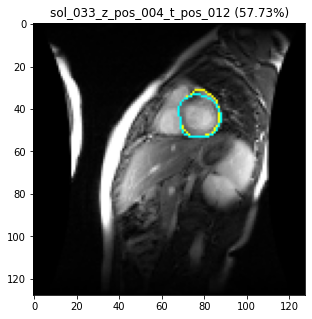

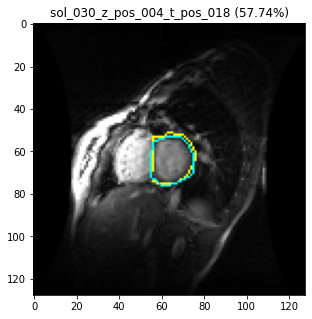

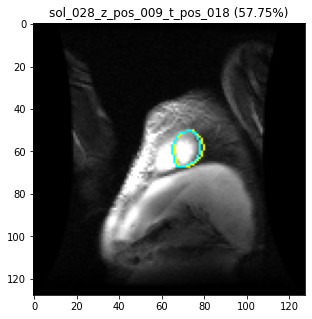

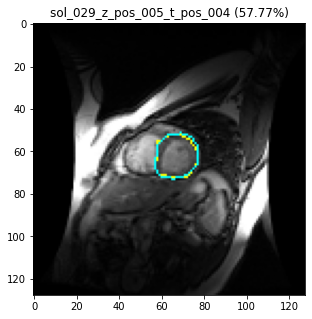

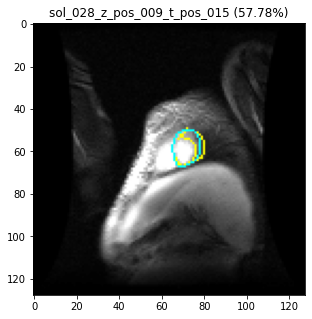

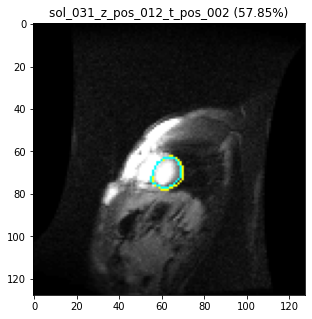

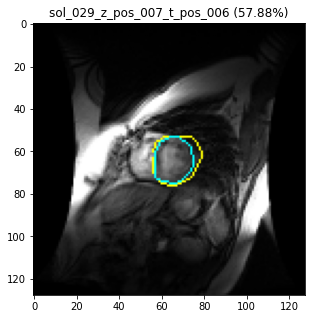

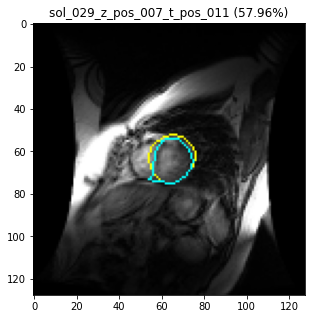

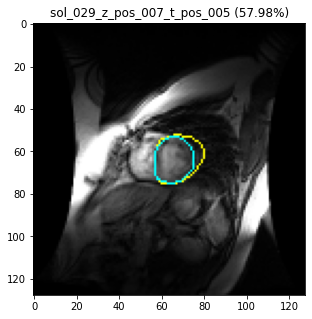

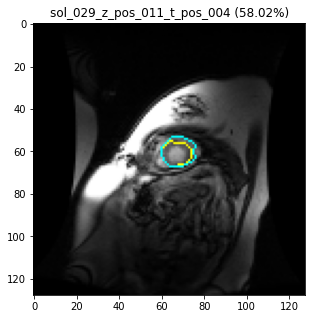

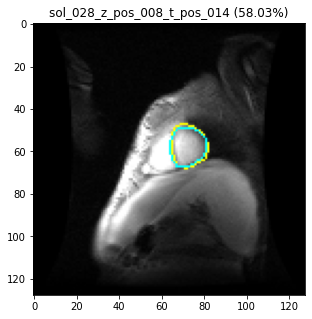

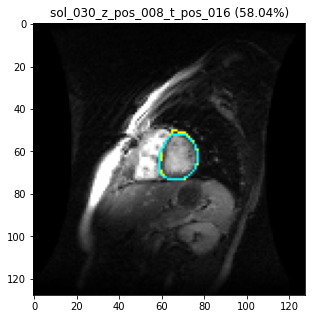

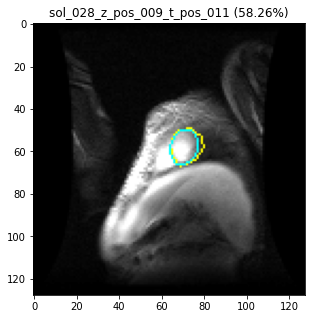

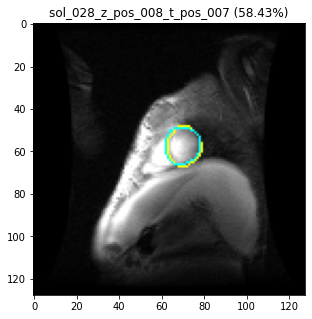

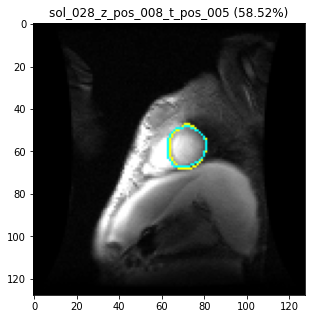

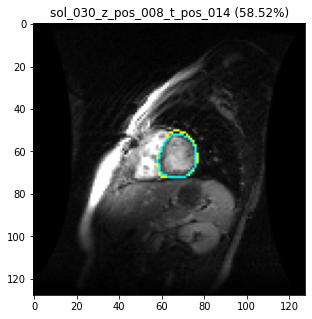

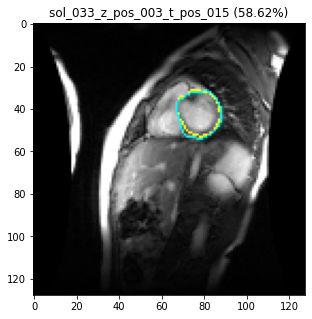

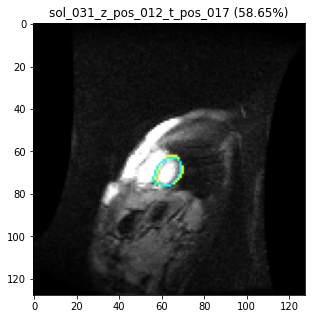

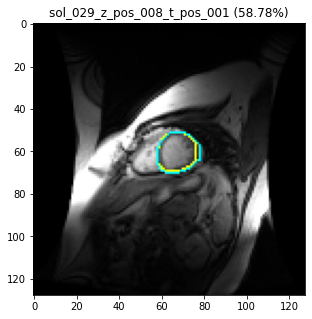

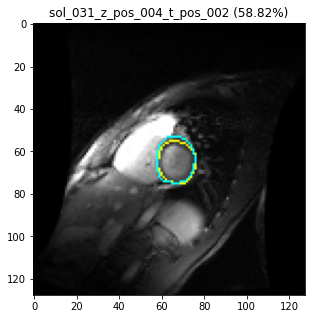

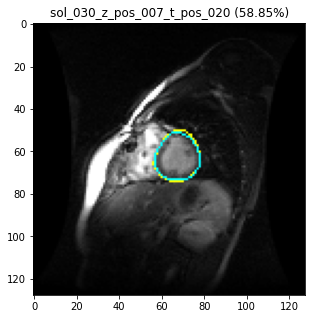

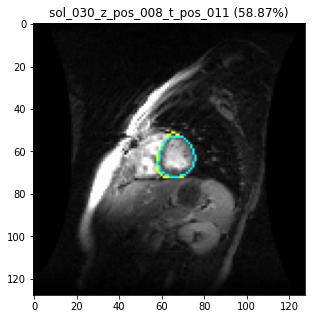

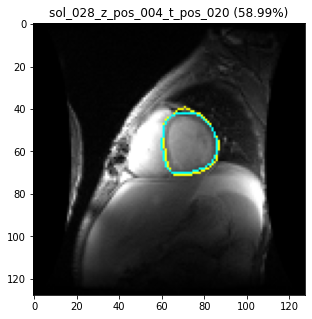

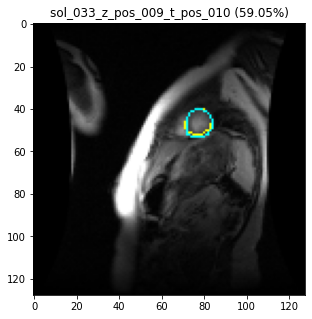

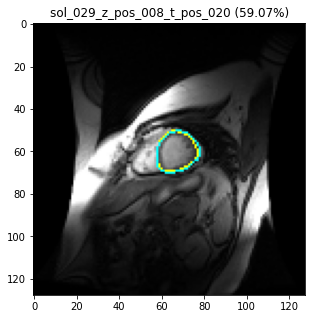

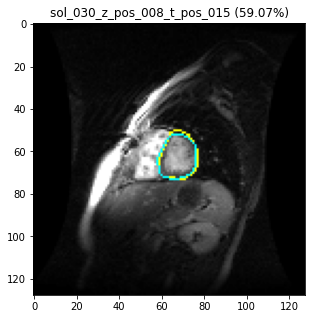

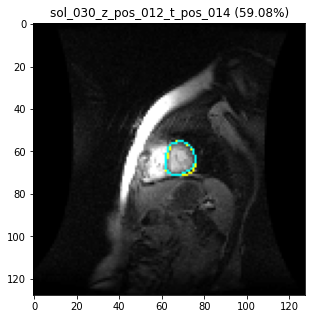

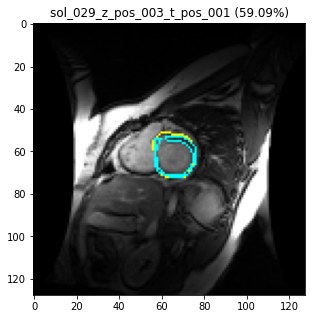

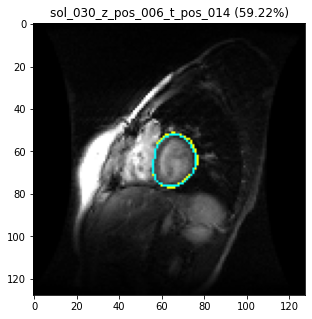

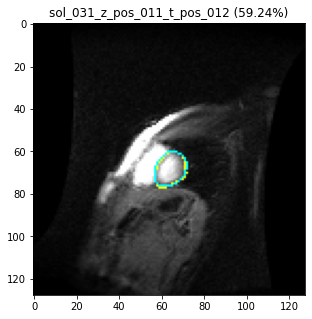

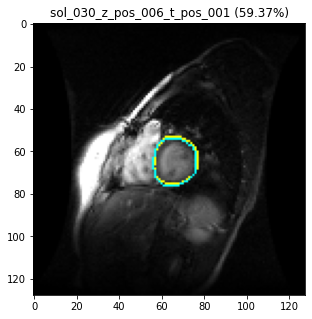

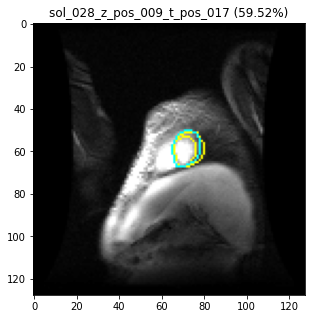

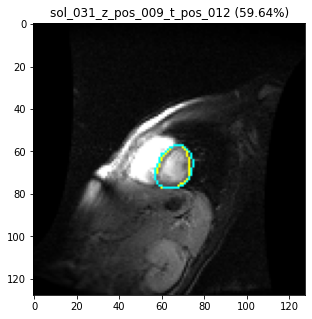

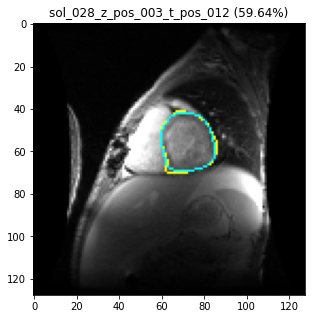

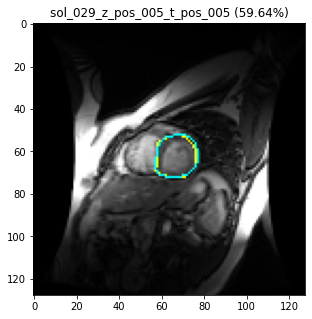

In [ ]:
for i in range(len(test_id3[50:100])):
  fungsi_vis(i,test_id3[50:100])

1/1 [==============================] - 0s 13ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 0s 12ms/step


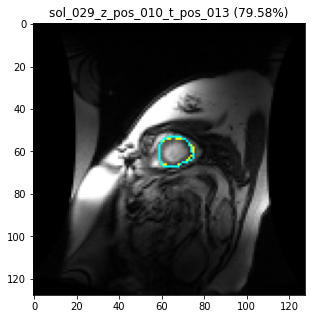

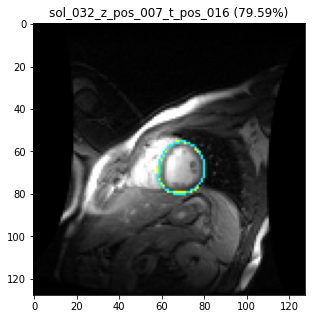

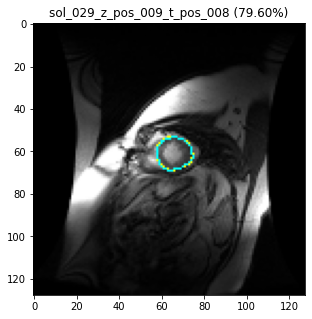

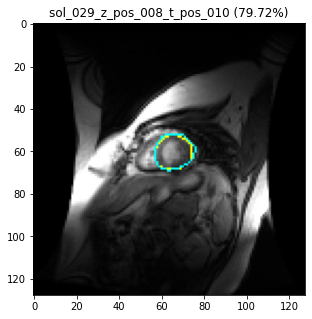

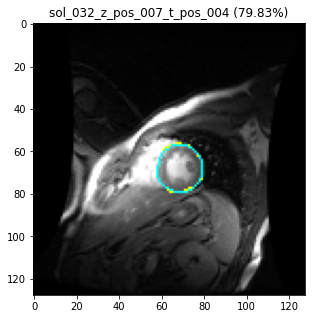

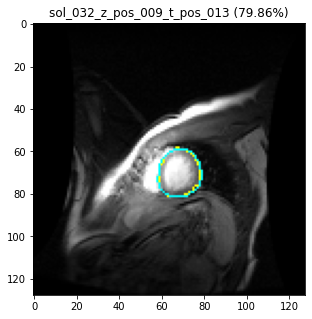

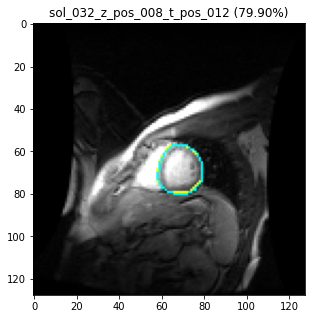

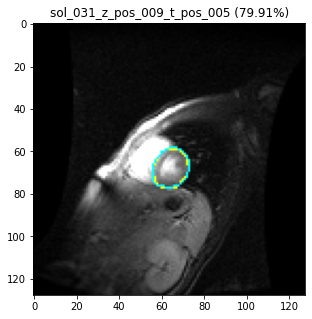

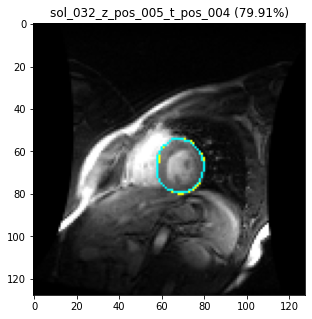

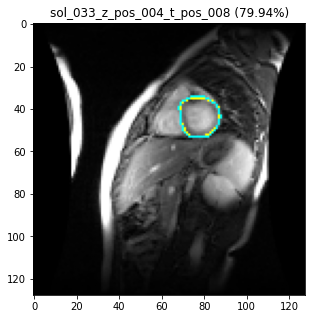

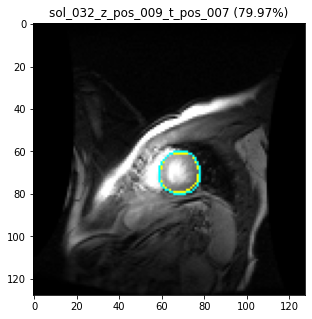

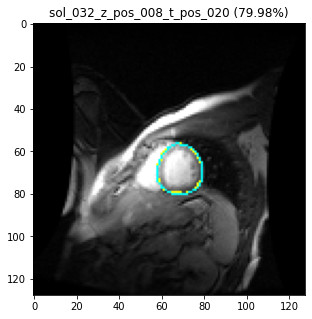

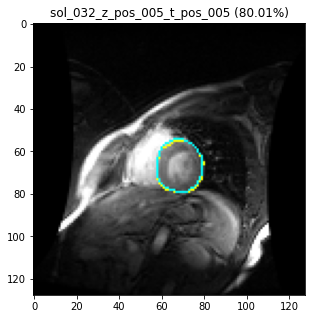

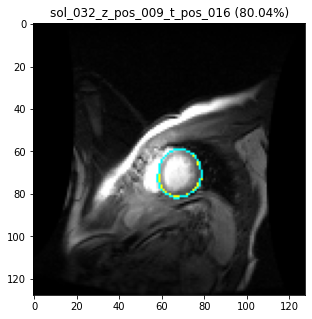

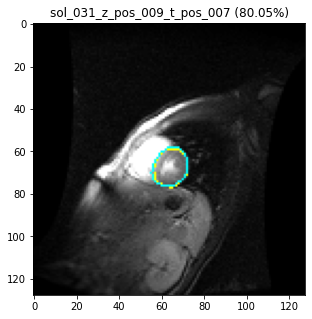

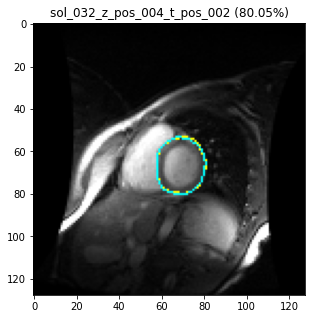

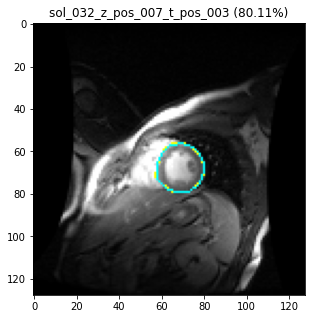

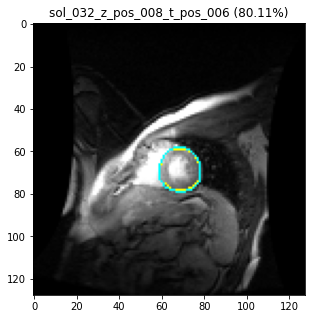

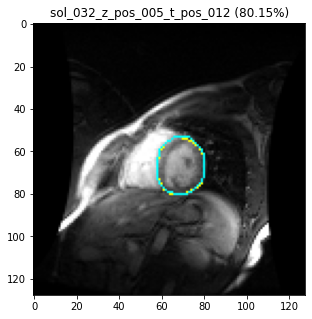

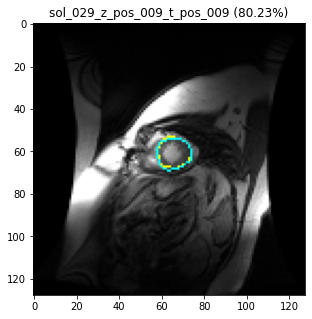

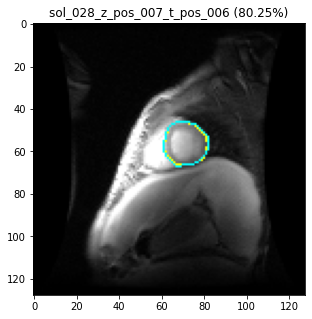

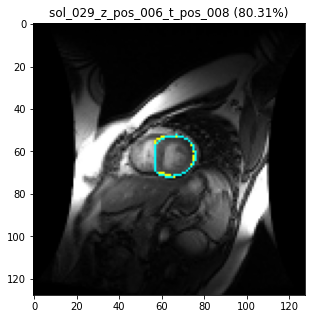

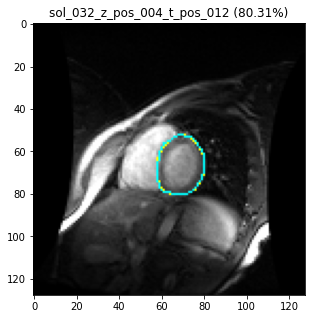

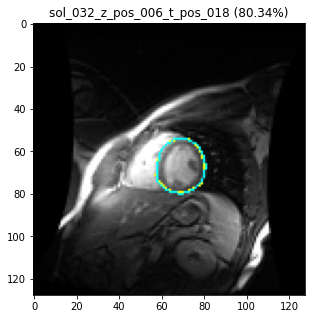

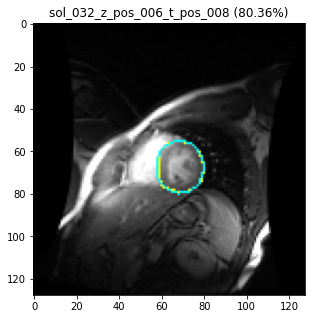

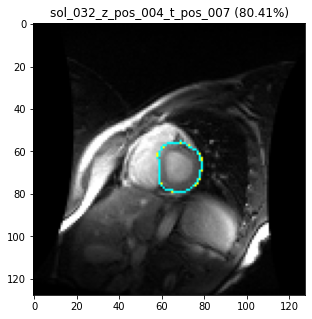

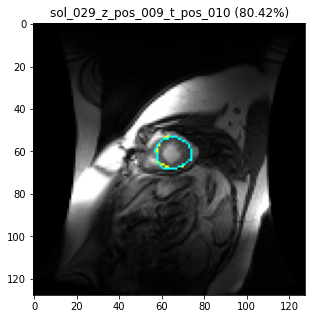

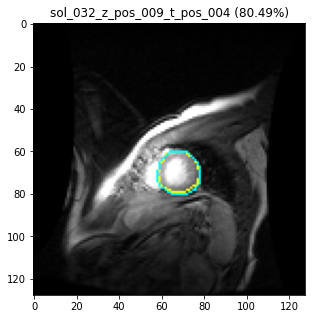

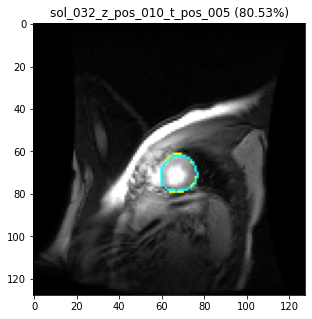

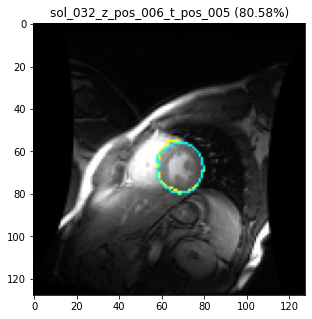

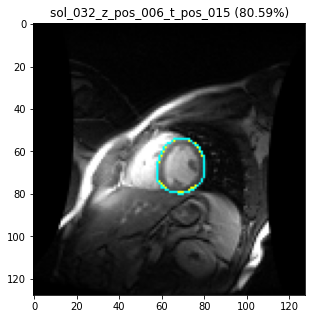

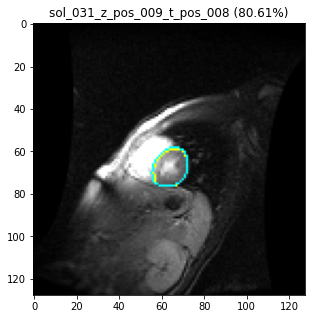

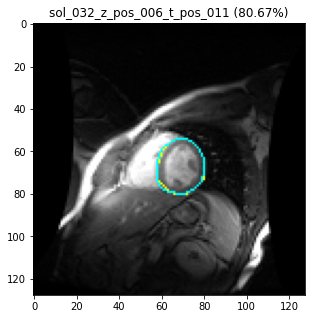

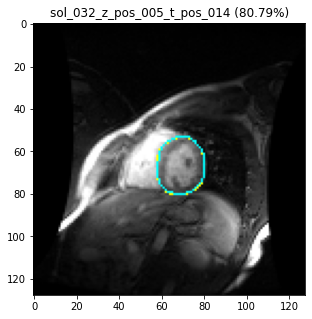

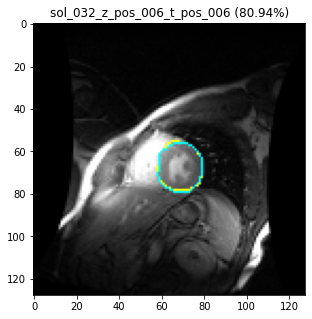

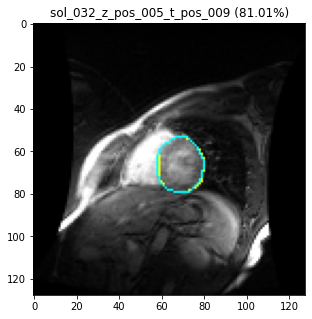

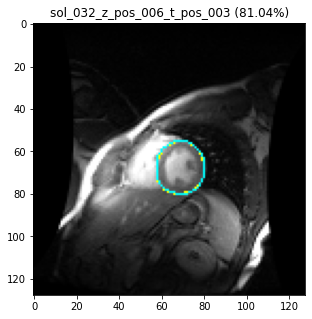

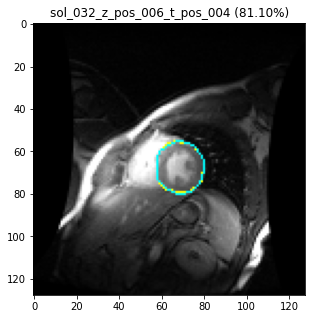

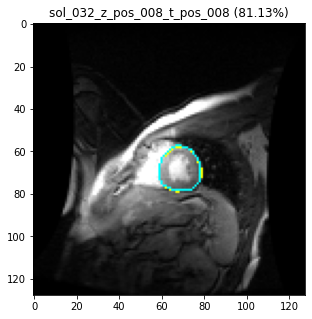

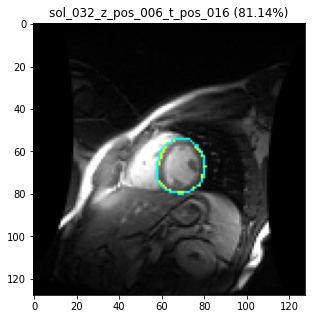

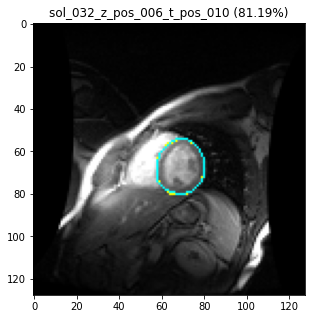

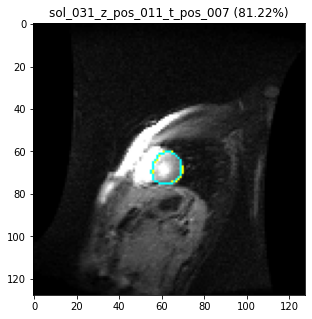

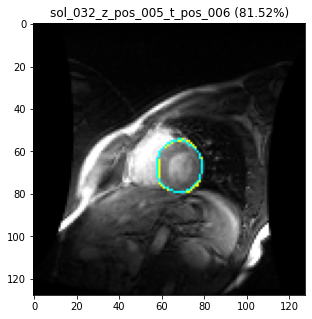

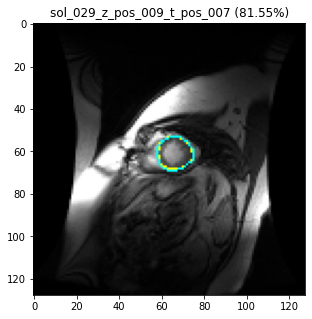

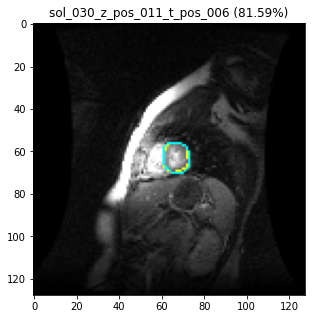

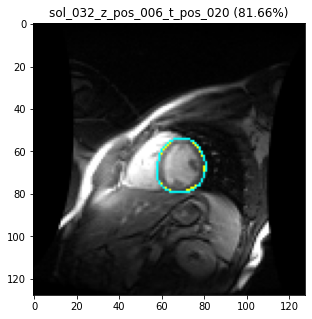

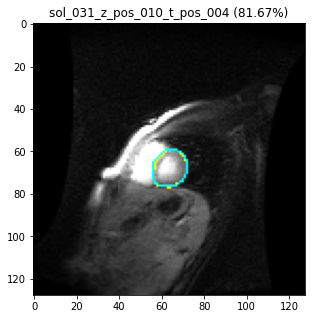

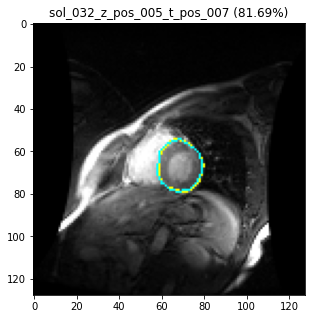

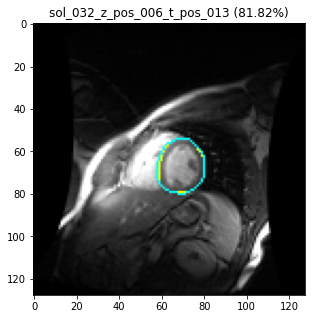

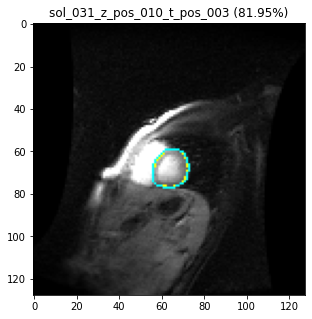

In [ ]:
for i in range(len(test_id3[-70:-20])):
  fungsi_vis(i,test_id3[-70:-20])

1/1 [==============================] - 0s 12ms/step


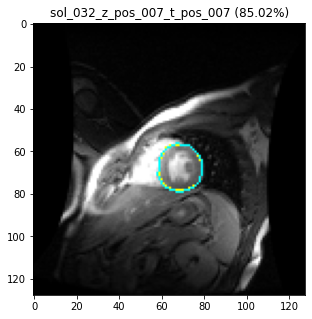

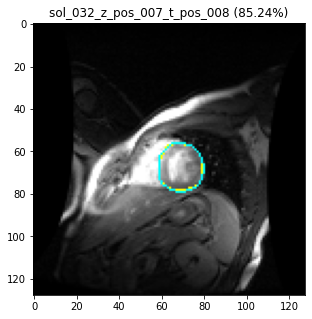

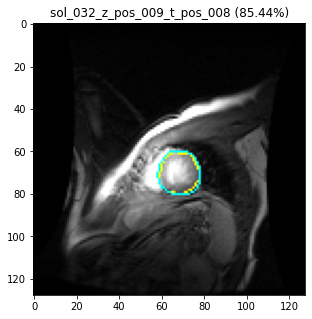

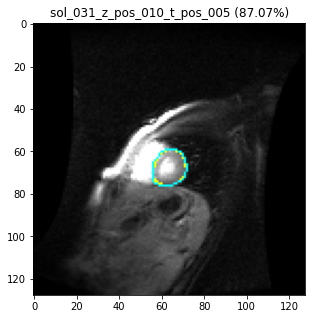

In [ ]:
for i in range(len(test_id4[:20])):
  fungsi_vis(i,test_id4[:20])

In [ ]:
for i in range(len(test_id4[-120:-80])):
  fungsi_vis(i,test_id4[-120:-80])

In [ ]:
for i in range(len(test_id5)):
  fungsi_vis(i,test_id5)

In [ ]:
##########____________________________________________________________________________##########

# Gambar yang akan dievaluasi (Definisikan!!!)
jenisimg = ['own','97','90','85','70','50','20','0,01','0,001'] # Kategori Berdasarkan Mean-IoU-Scores
eval_ids = ['sol_001_z_pos_002_t_pos_001','sol_001_z_pos_002_t_pos_015','sol_001_z_pos_002_t_pos_016','sol_001_z_pos_002_t_pos_017','sol_001_z_pos_002_t_pos_019','sol_001_z_pos_002_t_pos_020','sol_001_z_pos_003_t_pos_002','sol_001_z_pos_003_t_pos_003','sol_001_z_pos_003_t_pos_004']

link_fldr = '/content/drive/My Drive/SKRIPSI/visualisasi/'

##########____________________________________________________________________________##########

In [ ]:
eval_data = DataGen(eval_ids, train_path, image_size=image_size, batch_size=1)
x,y = eval_data.__getitem__(0)

In [ ]:
from keras import backend as K

# Print Image Input Layers
def printInput(x,y,i):
    print(x[0].shape)
    b,g,r = cv2.split(x[0])
    rgb_img = cv2.merge([r,g,b]) 
    pr = model.predict(x)
    fig, axs = plt.subplots(1, 6, figsize=(30,5))
    fig.suptitle('(0) Layer Input')
    axs[0].imshow(rgb_img) # Image
    axs[0].set_title('Image '+eval_ids[i]+' with score: '+jenisimg[i]+'%')
    axs[1].imshow(x[0][:,:,0]) # Blue
    axs[1].set_title('Blue channel '+eval_ids[i]+' with score: '+jenisimg[i]+'%')
    axs[2].imshow(x[0][:,:,1]) # Green
    axs[2].set_title('Green channel '+eval_ids[i]+' with score: '+jenisimg[i]+'%')
    axs[3].imshow(x[0][:,:,2]) # Red
    axs[3].set_title('Red channel '+eval_ids[i]+' with score: '+jenisimg[i]+'%')
    axs[4].imshow(y[0][:,:,0]) # Mask
    axs[4].set_title('Mask '+eval_ids[i]+' with score: '+jenisimg[i]+'%')
    axs[5].imshow(pr[0][:,:,0]) # Predict
    axs[5].set_title('Predict '+eval_ids[i]+' with score: '+jenisimg[i]+'%')

    fig.savefig(link_fldr+eval_ids[i]+'/(0) Layer Input.png')
    print("Success save layer input...")

# Pembagi Plot Size 
def rec(size_,pem=2,pen=2):
    hs = size_/4
    if size_ == 1: return pem-pem, pen-pen
    if hs == 1: return pem, pen
    elif hs % 4 != 0: return pem, pen*2
    else: return rec(hs,pem*2,pen*2)

# Print Image Every Layers
def printLayer(model,x,k,first_,last_):
    for i in range(first_,last_):
        print('('+str(i)+') Layer '+model.layers[i].name+'.png')
        if 'concat' in model.layers[i].name or 'pad' in model.layers[i].name:
            print('Skip layer '+model.layers[i].name)
        else:
            get_output = K.function([model.layers[0].input],
                                    [model.layers[i].output])
            
            layer_output = get_output([x])[0]

            pem, pen = rec(len(layer_output[0][0][0]))

            if pem == 0:
                plt.imshow(layer_output[0][...,0])
                plt.title("Ch_1")
                # Save Subplot.
                plt.savefig(link_fldr+eval_ids[k]+'/('+str(i)+') Layer '+model.layers[i].name+'.png')
            else:

                # Create a Subplot.
                fig, axs = plt.subplots(pen, pem, figsize=(32,32*pen//pem))
                fig.suptitle('('+str(i)+') Layer '+model.layers[i].name)
                
                for ii in range(pen):
                    for j in range(pem):
                        axs[ii, j].imshow(layer_output[0][...,(ii*pem)+j])
                        axs[ii, j].axis('off')
                        axs[ii, j].set_title("Ch_"+str((ii*pem)+j+1))
                
                # Save Subplot.
                fig.savefig(link_fldr+eval_ids[k]+'/('+str(i)+') Layer '+model.layers[i].name+'.png')

            print("Success save layer "+model.layers[i].name+"...")
            print()

In [ ]:
# Definisikan lt berdasarkan urutan gambar (dibagi supaya ram tidak penuh)
lt = 0

print('Percobaan kurang:',len(eval_ids)-lt-1,'gambar')


Percobaan kurang: 8 gambar


In [ ]:
# Execute 1/2 data
for i in range(lt,lt+1):
    print(eval_ids[i])
    try:
        os.mkdir(link_fldr+eval_ids[i]+'/')
    except FileExistsError:
        print('Directory not created, '+eval_ids[i]+' was exist!')
    x_,y_ = eval_data.__getitem__(i)
    printInput(x_,y_,i)
    printLayer(model,x_,i,1,len(model.layers)//2)
    print()


In [ ]:
    # Execute 2/2 data
for i in range(lt,lt+1):
   print(eval_ids[i])
    try:
        os.mkdir(link_fldr+eval_ids[i]+'/')
    except FileExistsError:
        print('Directory not created, '+eval_ids[i]+' was exist!')
    x_,y_ = eval_data.__getitem__(i)
    printInput(x_,y_,i)
    printLayer(model,x_,i,len(model.layers)//2,len(model.layers))
    print()

sol_001_z_pos_002_t_pos_001
Directory not created, sol_001_z_pos_002_t_pos_001 was exist!
(128, 128, 3)
Success save layer input...
(64) Layer conv_dw_10_relu.png
Success save layer conv_dw_10_relu...

(65) Layer conv_pw_10.png





#### Finish !

![alt text]Finish !... Semua File Akan Otomatis Replace

**Penting !...** *``Cara memastikan model sudah 500 epochs yaitu dengan melihat 

---

size pada file "history.bin", ketika sudah berukuran **"91KB"** artinya model tersebut sudah 500 epochs...*

#Skenario

##berat

## grid search/normal search

##stabil

In [ ]:

#############___________________#############

models_name = [
               'unet_mobilenet_17a_0.001_100_256_yes',
               'unet_mobilenet_jt_0.001_10_256_yes',
               'unet_mobilenet_jt_0.001_50_256_yes',
               'unet_mobilenet_jt_0.001_100_256_yes',
               'unet_mobilenet_jt_0.001_500_256_yes',
               'unet_mobilenet_jt_0.001_15_256_yes',
]

list_models = []
list_iousbest = []



for name in models_name:
    list_models.append(name)
    model.load_weights(save_dir[0]+name+'/'+name+'_best_weights.h5')
    print(model.name+'_bestweight')
    testing = test_eval(model)
    list_iousbest.append(testing[1]) # tambahin ini dis

import pandas as pd
print(len(list_models))
print(len(list_iousbest))
pd.DataFrame({'model':list_models, 'test_best': list_iousbest}).to_csv('balancing_model_this.xls', index=False)

#_______ UNTUK TEST_EVAL SEMUA MODEL _______# 

In [ ]:

#############___________________#############

models_name = [
               'unet_mobilenet_17a_0.001_100_256_yes', 
               'unet_mobilenet_jt_0.001_500_256_yes', 
               'unet_mobilenet_jt_0.001_50_256_yes',
               'unet_mobilenet_jt_0.001_15_256_yes' 
]

list_models = []
list_iousbest = []


for name in models_name:
    list_models.append(name)
    model.load_weights(save_dir[0]+name+'/'+name+'_best_weights.h5')
    print(model.name+'_bestweight')
    testing = test_eval(model)
    list_iousbest.append(testing[1])


# import pandas as pd
# pd.DataFrame({'model':list_models, 'test_best': list_iousbest, 'test_last': list_iouslast}).to_csv('balancing_model_this.xls', index=False)

#_______ UNTUK TEST_EVAL SEMUA MODEL _______# 

In [ ]:
for namee in sorted(os.listdir('bin/')):
    if '192' in namee:
        histoo = loadHist('bin/'+namee)
        print(namee, histoo['val_iou_score'].index(max(histoo['val_iou_score']))+1)

In [ ]:
model.name

In [ ]:
# for i_ in range(len(list_models)):
#     image_size = int(list_models[i_].name.split('_')[5])
#     train_gen, test_gen, valid_gen, train_steps, test_steps, valid_steps = set_data(train_17_ids,test_17_ids,valid_17_ids)
#     test_vis(list_models[i_], test_ids=test_17_ids, evals=True)


In [ ]:
x,y = test_gen.__getitem__(0)

# OpenCV does not use RGB, it uses BGR (standing for blue, green, red). You need to swap the order of the red and the blue.
b,g,r = cv2.split(x[0])           # get b, g, r
rgb_img = cv2.merge([r,g,b])     # switch it to r, g, b

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0, 0].imshow(x[0].squeeze())
axs[0, 0].set_title('bgr image')

axs[0, 1].imshow(denormalize(x[0]))
axs[0, 1].set_title('bgr image denorm')

axs[1, 0].imshow(rgb_img)
axs[1, 0].set_title('rgb image')

axs[1, 1].imshow(denormalize(rgb_img))
axs[1, 1].set_title('rgb image denorm')

**Percobaaan pengambilan epochs terbaik**

In [ ]:
import pandas as pd

list_hist = {}
best_models = {} 

for dirs in os.listdir(save_dir[0]):
    if '.h5' in dirs or 'pretrained' in dirs or 'sm' in dirs or 'linknet' in dirs or '0.001_500_128_yes' in dirs:
        continue
    else:
        path_dir = save_dir[0]+dirs+'/'
        for dir_file in os.listdir(path_dir):
            if 'history.bin' in dir_file:
                list_hist[dirs] = loadHist(path_dir+dirs+'_history.bin')
                val_i = list_hist[dirs]['val_iou_score']
                maxim = 0
                for ep in range(len(val_i)):
                    if maxim < val_i[ep]:
                        maxim = val_i[ep]
                        dirs = dirs.replace('_100_','_500_')
                        best_models[dirs] = (maxim,ep+1)


bsms = [bsm for bsm in best_models]
epochsm = [best_models[bsm][1] for bsm in best_models]
valsm = [best_models[bsm][0] for bsm in best_models]
df_epochs = pd.DataFrame({'model':bsms, 'epochs': epochsm, 'val_score': valsm})
df_epochs.sort_values(ascending=False,axis=0,by='val_score').reset_index().drop(['index'],axis=1).to_csv('epochs_best_test.xls')

In [ ]:
last_models = {} 

for dirs in os.listdir(save_dir[0]):
    # if '.h5' in dirs or 'pretrained' in dirs or 'sm' in dirs or 'linknet' in dirs or '0.001_500_128_yes' in dirs:
    #     continue
    # else:
        path_dir = save_dir[0]+dirs+'/'
        for dir_file in os.listdir(path_dir):
            if 'history.bin' in dir_file:
                val_i = loadHist(path_dir+dirs+'_history.bin')['val_iou_score']
            if 'scores.txt' in dir_file:
                test_i = open(path_dir+dirs+'_scores.txt', 'r').read().split()
                dirs = dirs.replace('_100_','_500_')
                last_models[dirs] = (val_i[-1],test_i[4])


bsms = [bsm for bsm in last_models]
testsm = [last_models[bsm][1] for bsm in last_models]
valsm = [last_models[bsm][0] for bsm in last_models]
df_epochs = pd.DataFrame({'model':bsms, 'val_score': valsm, 'test_score': testsm})
df_epochs.sort_values(ascending=False,axis=0,by='test_score').reset_index().drop(['index'],axis=1)

In [ ]:
eval_data = DataGen(eval_ids, train_path, image_size=128, batch_size=1)
x,y = eval_data.__getitem__(0)
b,g,r = cv2.split(x[0])
rgb_img = cv2.merge([r,g,b]) 
pr = model.predict(x)
fig, axs = plt.subplots(1, 6, figsize=(30,5))
axs[0].imshow(rgb_img) # Image
axs[1].imshow(x[0][:,:,0], cmap='gray') # Blue
axs[2].imshow(x[0][:,:,1], cmap='gray') # Green
axs[3].imshow(x[0][:,:,2], cmap='gray') # Red
axs[4].imshow(y[0][:,:,0], cmap='gray') # Mask
axs[5].imshow(pr[0][:,:,0], cmap='gray') # Predict

list_cmap = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn,' 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted']
fig, axs = plt.subplots(1, len(list_cmap), figsize=(240,5))
for i in range(len(list_cmap)):
  try:
    axs[i].imshow(x[0][:,:,0], cmap=list_cmap[i])
    axs[i].axis('off')
    axs[i].set_title(list_cmap[i])
  except:
    print(list_cmap[i])

In [ ]:
#segmentation_models.metrics padahal ada dice-nya tapi ga ke load kenapa?
model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim = take_model('unet_mobilenet_jt_0.001_15_256_yes')
model.save_weights(save_dir[0]+'unet_mobilenet_jt_0.001_15_256_yes.h5')

In [ ]:
gambar_sample = ['sol_001_z_pos_002_t_pos_001','sol_001_z_pos_002_t_pos_015','sol_001_z_pos_002_t_pos_016','sol_001_z_pos_002_t_pos_017','sol_001_z_pos_002_t_pos_019','sol_001_z_pos_002_t_pos_020','sol_001_z_pos_003_t_pos_002','sol_001_z_pos_003_t_pos_003','sol_001_z_pos_003_t_pos_004']

In [ ]:
#kalo ga ada 128 gimana?
list_model_128 = [
             'unet_mobilenet_17a_0.001_100_256_yes',
               'unet_mobilenet_17a_0.001_100_256_no',
               'unet_mobilenet_jt_0.001_10_256_yes',
               'unet_mobilenet_jt_0.001_10_256_no',
               'unet_mobilenet_jt_0.001_50_256_yes',
               'unet_mobilenet_jt_0.001_50_256_no',
               'unet_mobilenet_jt_0.001_100_256_yes',
               'unet_mobilenet_jt_0.001_100_256_no',
               'unet_mobilenet_jt_0.001_500_256_yes',
               'unet_mobilenet_jt_0.001_500_256_no',
               'unet_mobilenet_jt_0.001_15_256_yes',
               'unet_mobilenet_jt_0.001_15_256_no'
]

model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim = take_model('unet_mobilenet_jt_0.001_15_256_yes')

# for m in list_model_128:
#     train_gen, test_gen, valid_gen, train_steps, test_steps, valid_steps = set_data(train_17_ids,test_17_ids,valid_17_ids)
#     print()
#     print('Loading weight...')
#     model.name = m
#     model.load_weights(save_dir[0]+m+'.h5')
#     test_vis(model, test_ids=test_17_ids, evals=False, id_=gambar_sample)

# print grafik
for m in list_model_128:
    print('Loading weight...')
    model.load_weights(save_dir[0]+m+'.h5')
    train_vis(model.history.history, save_dir[0]+m+'/'+m, doing="save")

In [ ]:
list_model_256 = [
               'unet_mobilenet_17a_0.001_100_256_yes',
               'unet_mobilenet_jt_0.001_10_256_yes',
               'unet_mobilenet_jt_0.001_50_256_yes',
               'unet_mobilenet_jt_0.001_100_256_yes',
               'unet_mobilenet_jt_0.001_500_256_yes',
               'unet_mobilenet_jt_0.001_15_256_yes',
]

model, lr, epochs, image_size, pretrained, batch_size, metrics, total_loss, optim = take_model('unet_mobilenet_17a_0.001_100_128_yes')

for m in list_model_256:
    train_gen, test_gen, valid_gen, train_steps, test_steps, valid_steps = set_data(train_jt_ids,test_jt_ids,valid_jt_ids)
    print()
    print('Loading weight...')
    model.name = m
    model.load_weights(save_dir[0]+m+'.h5')
    test_vis(model, test_ids=test_17_ids, evals=False, id_=gambar_sample)

In [ ]:
!pip install patool

In [ ]:
#doesn't need at all
#import patoolib
#patoolib.create_archive('/content/drive/My Drive/vis.zip', ('/content/filevis',), program=None)

## bayesian optimazion

## ganti ukuran citra